In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import re
import json
import requests
from bs4 import BeautifulSoup
import datetime
from pprint import pprint

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# load wrangle.csv file
df = pd.read_csv('wrangle.csv', index_col=0)
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


In [4]:
# add revenue column
# change unit to 1 million
df['revenue'] = df.gross - df.budget
df.budget = df['budget'] / 1000000
df.gross = df['gross'] / 1000000
df.revenue = df['revenue'] / 1000000

In [5]:
# remove gross column
df = df.drop(['gross', 'budget'], axis=1)

In [6]:
# reset index to a sequential number
df = df.reset_index(drop=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 27 columns):
color                        4099 non-null object
director_name                4099 non-null object
num_critic_for_reviews       4094 non-null float64
duration                     4098 non-null float64
director_facebook_likes      4099 non-null float64
actor_3_facebook_likes       4088 non-null float64
actor_2_name                 4094 non-null object
actor_1_facebook_likes       4096 non-null float64
genres                       4099 non-null object
actor_1_name                 4096 non-null object
movie_title                  4099 non-null object
num_voted_users              4099 non-null int64
cast_total_facebook_likes    4099 non-null int64
actor_3_name                 4088 non-null object
facenumber_in_poster         4092 non-null float64
plot_keywords                4060 non-null object
movie_imdb_link              4099 non-null object
num_user_for_reviews         4099 non-n

### Compare the percentage of positive and negative revnue 

In [8]:
positive = df[df['revenue'] > 0]['revenue']
negative = df[df['revenue'] <= 0]['revenue']

In [9]:
money = float(len(positive)) / float(len(positive)+len(negative))
no_money = float(len(negative)) / float((len(positive)+len(negative)))

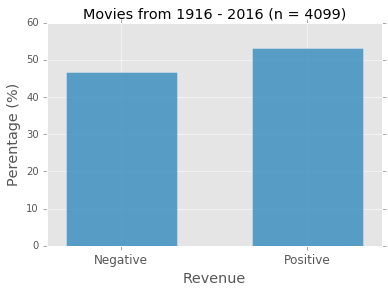

In [10]:
objects = ('Negative', 'Positive')
y_pos = np.arange(len(objects))
performance = [no_money*100, money*100]
 
plt.style.use('ggplot')
plt.bar(y_pos, performance, alpha=0.8, width=0.6, align='center')
plt.xlabel('Revenue', fontsize='x-large')
plt.ylabel('Perentage (%)', fontsize='x-large')
plt.title('Movies from 1916 - 2016 (n = 4099)', fontsize='x-large')
plt.xticks(np.arange(2), ['Negative', 'Positive'], fontsize='large')
plt.savefig('bar.eps', format='eps', dpi=1000)

### Add month column; group them into 1: June and December or 0: other months

In [11]:
import json
with open('scraping/imdb_month.json', 'r') as f:
    imdb_month = json.load(f)

In [12]:
len(imdb_month)

3657

In [13]:
# use link to put month into month column
df['month'] = df.movie_imdb_link.map(imdb_month)

In [14]:
df.loc[:, 'month'] = df['month'].str[0]

In [15]:
df.loc[:, 'month'] =df.loc[:, 'month'].str.replace('\d+ ', '')

In [16]:
# June and December = 1; others =0
for i in range(0, 4099):
    if df.loc[i, 'month'] == 'June' or df.loc[i, 'month'] == 'December':
        df.loc[i, 'month'] = 1
    else:
        df.loc[i, 'month'] = 0

In [17]:
Counter(df.month)

Counter({0: 3510, 1: 589})

In [18]:
print 'The revenue in the popular season is {}'.format(df.revenue[df['month'] == 1].mean())
print 'The revenue in the non-popular season is {}'.format(df.revenue[df['month'] == 0].mean())

The revenue in the popular season is 23.6463799525
The revenue in the non-popular season is 2.56547505698


### Replace director_name to their frequency

In [19]:
director_freq = Counter(df.director_name)

In [20]:
df.director_name = df.director_name.map(director_freq)

### Replace actor_name to their frequency

In [21]:
actor = ['actor_1_name', 'actor_2_name', 'actor_3_name']
for i in actor:
    freq = Counter(df[i])
    df[i] = df[i].map(freq)

### Dummify generes column

In [22]:
s = df['genres'].str.split('|', expand=False)
dummy = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
dummy = dummy.astype('float')

In [23]:
df = pd.concat([df, dummy], axis=1)

In [24]:
df = df.drop('genres', axis=1)

### subgroup content_rating into 4 groups

In [25]:
for i in range(0, 4099):
    if df.loc[i, 'content_rating'] == 'PG' or df.loc[i, 'content_rating'] == 'PG-13' or df.loc[i, 'content_rating'] == 'R':
        df.loc[i, 'content_rating'] = df.loc[i, 'content_rating']
    else:
        df.loc[i, 'content_rating'] = 'others'

In [26]:
Counter(df.content_rating)

Counter({'PG': 625, 'PG-13': 1341, 'R': 1812, 'others': 321})

In [27]:
for i in ['PG', 'PG-13', 'R', 'others']:
    x = df.revenue[df['content_rating'] == i].mean()
    print x

21.1194381808
11.7948935108
-5.04273480905
9.512055


In [28]:
dummy = pd.get_dummies(df.content_rating, drop_first=True)
df = pd.concat([df, dummy], axis=1)
df = df.drop('content_rating', axis=1)

In [29]:
df[['PG-13', 'R', 'others']] = df[['PG-13', 'R', 'others']].astype(float)

### Remove unrelated columns

In [30]:
unrelated_col = ['country', 'language','color','aspect_ratio', 'plot_keywords', 'movie_imdb_link', 'movie_title', 'duration', 'title_year', 'facenumber_in_poster']
df= df.drop(unrelated_col, axis=1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 43 columns):
director_name                4099 non-null int64
num_critic_for_reviews       4094 non-null float64
director_facebook_likes      4099 non-null float64
actor_3_facebook_likes       4088 non-null float64
actor_2_name                 4099 non-null int64
actor_1_facebook_likes       4096 non-null float64
actor_1_name                 4099 non-null int64
num_voted_users              4099 non-null int64
cast_total_facebook_likes    4099 non-null int64
actor_3_name                 4099 non-null int64
num_user_for_reviews         4099 non-null float64
actor_2_facebook_likes       4094 non-null float64
imdb_score                   4099 non-null float64
movie_facebook_likes         4099 non-null int64
revenue                      4099 non-null float64
month                        4099 non-null int64
Action                       4099 non-null float64
Adventure                    4099 non-null

### Check correlation matrix
* actor_1_facebook_likes & cast_total_facebook_likes columns have ~ 0.8 correlation
* drop actor_1_facebook_likes column

In [32]:
cor = df.corr()

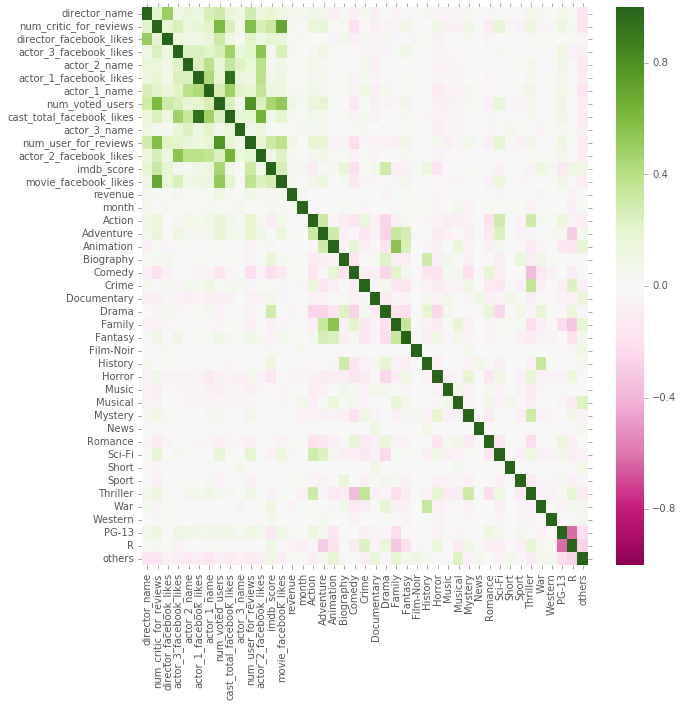

In [33]:
plt.figure(figsize=(10, 10))
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, cmap='PiYG', vmax=1, vmin=-1) 
# Put annotation in the heatmap by two parameters: annot=True, annot_kws={"size": 10}

In [34]:
# check the highest coreelation between two features
for i in cor.columns:
    for j in cor.index:
        if (cor.loc[j, i] > 0.7) & (cor.loc[j, i] < 1):
            print i + ' / ' + j

actor_1_facebook_likes / cast_total_facebook_likes
num_voted_users / num_user_for_reviews
cast_total_facebook_likes / actor_1_facebook_likes
num_user_for_reviews / num_voted_users


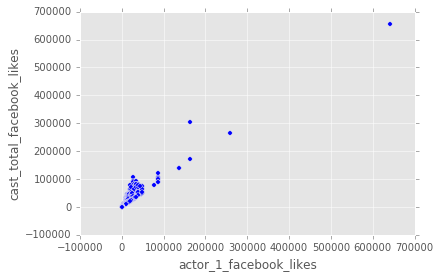

In [36]:
plt.scatter(x=df.actor_1_facebook_likes, y=df.cast_total_facebook_likes)
plt.xlabel('actor_1_facebook_likes')
plt.ylabel('cast_total_facebook_likes')

In [37]:
df = df.drop('actor_1_facebook_likes', axis=1)

In [60]:
df = df[(df.revenue > -400)]

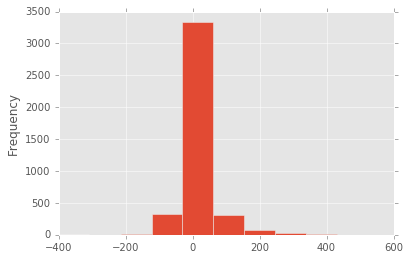

In [61]:
df['revenue'].plot(kind='hist')

In [ ]:
plt.scatter(x=df.num_voted_users, y=df.num_user_for_reviews)
plt.xlabel('num_voted_users')
plt.ylabel('num_user_for_reviews')

### replace NaN with mean 

In [38]:
df.isnull().sum()

director_name                 0
num_critic_for_reviews        5
director_facebook_likes       0
actor_3_facebook_likes       11
actor_2_name                  0
actor_1_name                  0
num_voted_users               0
cast_total_facebook_likes     0
actor_3_name                  0
num_user_for_reviews          0
actor_2_facebook_likes        5
imdb_score                    0
movie_facebook_likes          0
revenue                       0
month                         0
Action                        0
Adventure                     0
Animation                     0
Biography                     0
Comedy                        0
Crime                         0
Documentary                   0
Drama                         0
Family                        0
Fantasy                       0
Film-Noir                     0
History                       0
Horror                        0
Music                         0
Musical                       0
Mystery                       0
News    

In [39]:
from sklearn.preprocessing import Imputer

In [40]:
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [41]:
df['actor_2_facebook_likes'] = imr.fit_transform(df[['actor_2_facebook_likes']]).ravel()

In [42]:
df['actor_3_facebook_likes'] = imr.fit_transform(df[['actor_3_facebook_likes']]).ravel()

In [43]:
df['num_critic_for_reviews'] = imr.fit_transform(df[['num_critic_for_reviews']]).ravel()

In [44]:
df.isnull().sum()

director_name                0
num_critic_for_reviews       0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_name                 0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
num_user_for_reviews         0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
revenue                      0
month                        0
Action                       0
Adventure                    0
Animation                    0
Biography                    0
Comedy                       0
Crime                        0
Documentary                  0
Drama                        0
Family                       0
Fantasy                      0
Film-Noir                    0
History                      0
Horror                       0
Music                        0
Musical                      0
Mystery                      0
News                         0
Romance 

### Seaborn pairplot
* revenue's distribution is too skewed
 * set revenue > -400

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 0 to 4098
Data columns (total 42 columns):
director_name                4088 non-null int64
num_critic_for_reviews       4088 non-null float64
director_facebook_likes      4088 non-null float64
actor_3_facebook_likes       4088 non-null float64
actor_2_name                 4088 non-null int64
actor_1_name                 4088 non-null int64
num_voted_users              4088 non-null int64
cast_total_facebook_likes    4088 non-null int64
actor_3_name                 4088 non-null int64
num_user_for_reviews         4088 non-null float64
actor_2_facebook_likes       4088 non-null float64
imdb_score                   4088 non-null float64
movie_facebook_likes         4088 non-null int64
revenue                      4088 non-null float64
month                        4088 non-null int64
Action                       4088 non-null float64
Adventure                    4088 non-null float64
Animation                    4088 non-null

In [ ]:
sns.pairplot(df)

In [ ]:
plt.scatter(x='movie_facebook_likes', y='num_voted_users', data=df)

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
print IQR

In [ ]:
df[~((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).any(axis=1)]

# --------------------------

# Data prep for classification

In [62]:
df_logit = df.copy()
df_logit = df_logit.reset_index(drop=True)

In [65]:
for i in range(0, 4088):
    if df_logit.loc[i, 'revenue'] > 0:
        df_logit.loc[i, 'revenue'] = 1
    else:
        df_logit.loc[i, 'revenue'] = 0

In [66]:
X = df_logit.drop('revenue', axis=1)
y = df_logit['revenue']

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [68]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 1. Logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=100, random_state=1)

In [70]:
logit.fit(X_train_std, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
y_pred = logit.predict(X_test_std)

In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.68378158109209453

### look for the best hyperparameter C for logistic regression

In [73]:
params, score = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    predict = lr.predict(X_test_std)
    score.append(accuracy_score(y_test, predict))
    params.append(10.**c)

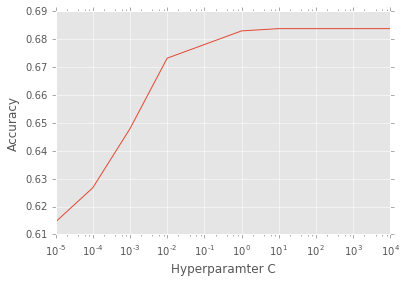

In [74]:
# C=0.001 has the highest accuracy
plt.plot(params, score)
plt.xscale('log')
plt.xlabel('Hyperparamter C')
plt.ylabel('Accuracy')

In [75]:
result = dict(zip(params, score))

In [76]:
pprint('The best C is {} and the best accuracy score is {}'.format(max(result, key=lambda k: result[k]), max(result.values())))

'The best C is 100.0 and the best accuracy score is 0.683781581092'


In [54]:
from sklearn.preprocessing import PolynomialFeatures

In [56]:
poly = PolynomialFeatures(degree=2)
X_train_std_poly = poly.fit_transform(X_train_std)
X_test_std_poly = poly.fit_transform(X_test_std)

In [57]:
logit.fit(X_train_std_poly, y_train)
y_pred = logit.predict(X_test_std_poly)

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6447154471544716

# 2. SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, probability=True, random_state=1)

In [ ]:
svm.fit(X_train_std, y_train)

In [ ]:
y_pred = svm.predict(X_test_std)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = svm.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### look for hyperparameter C for SVM by for loop

In [ ]:
params, score = [], []
for c in np.arange(-1, 4):
    clf = SVC(kernel='linear', C=10.**c, random_state=1)
    clf.fit(X_train_std, y_train)
    predict = clf.predict(X_test_std)
    score.append(accuracy_score(y_test, predict))
    params.append(10.**c)

In [ ]:
# C=100 has the highest accuracy
plt.plot(params, score)
plt.xscale('log')
plt.xlabel('Hyperparamter C')
plt.ylabel('Accuracy')

In [ ]:
result = dict(zip(params, score))

In [ ]:
print 'The best C for SVM is {} and accuracy score is {}'.format(max(result, key= lambda k: result[k]), max(result.values()))

### GridSearch CV

In [ ]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c = np.logspace(-5, 3, 10)
param_grid = {'C': c}

# Instantiate a logistic regression classifier: logreg
svm = SVC(kernel='linear', random_state=1)

# Instantiate the GridSearchCV object: logreg_cv
svm_cv = GridSearchCV(svm, param_grid, cv=5)

# Fit it to the data
svm_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score (TYPO ALERT!!! it should be svm instead of svm_rbf)
print("Tuned svm_rbf Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

In [ ]:
# test hold-out data
print 'The best C from SVM grid search is {} and the accuracy score is {}'.format(svm_cv.best_params_, accuracy_score(y_test, svm_cv.predict(X_test_std)))

# 3. Kernel SVM 

In [ ]:
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf', gamma = 0.1, C=1.0, random_state=1)
svm_rbf.fit(X_train_std, y_train)

In [ ]:
print accuracy_score(y_train, svm_rbf.predict(X_train_std)), accuracy_score(y_test, svm_rbf.predict(X_test_std))

### look for the best gamma and C in kernel SVM 

In [ ]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
r = np.logspace(-5, 2, 10)
c = np.logspace(-5, 2, 10)
param_grid = {'gamma': 10.**r, 'C': 10.**c}

# Instantiate a logistic regression classifier: logreg
svm_rbf = SVC(kernel='rbf', random_state=1)

# Instantiate the GridSearchCV object: logreg_cv
svm_rbf_cv = GridSearchCV(svm_rbf, param_grid, cv=5)

# Fit it to the data
svm_rbf_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score
print("Tuned svm_rbf Parameters: {}".format(svm_rbf_cv.best_params_)) 
print("Best score is {}".format(svm_rbf_cv.best_score_))

In [ ]:
# test hold-out data
print '{}. The accuracy score is {}'.format(svm_rbf_cv.best_params_, accuracy_score(y_test, svm_rbf_cv.predict(X_test_std)))

# 4. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X_train_std, y_train)

In [ ]:
print accuracy_score(y_train, knn.predict(X_train_std)), accuracy_score(y_test, knn.predict(X_test_std))

### look for best K with KNN (Euclidean)

In [ ]:
train_score = []
test_score = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knn.fit(X_train_std, y_train)
    predict1 = knn.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = knn.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

In [ ]:
k_range = range(1, 21)
plt.plot(k_range, train_score, marker='o', label='training score')
plt.plot(k_range, test_score, marker='+', color='red', label='testing score')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Search the best k for knn (Eluclidean)')
plt.legend()

In [ ]:
result= dict(zip(k_range, test_score))

In [ ]:
print 'The best K is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

### look for the best K with KNN (Manhattan)

In [ ]:
train_score = []
test_score = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    knn.fit(X_train_std, y_train)
    predict1 = knn.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = knn.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

In [ ]:
k_range = range(1, 21)
plt.plot(k_range, train_score, marker='o', label='training score')
plt.plot(k_range, test_score, marker='+', color='red', label='testing score')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Search the best k for knn (Manhattan)')
plt.legend()

In [ ]:
result= dict(zip(k_range, test_score))

In [ ]:
print 'The best K is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

# 5. Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(X_train_std, y_train)

In [ ]:
print accuracy_score(y_train, tree.predict(X_train_std)), accuracy_score(y_test, tree.predict(X_test_std))

### look for the best max_depth with tree

In [ ]:
depth = range(1, 21)
train_score = []
test_score = []
for t in depth:
    tree = DecisionTreeClassifier(criterion='gini', max_depth=t, random_state=1)
    tree.fit(X_train_std, y_train)
    predict1 = tree.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = tree.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

In [ ]:
plt.plot(depth, train_score, marker='o', label='training score')
plt.plot(depth, test_score, marker='+', color='red', label='testing score')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Search the best max_depth for tree (Gini)')
plt.legend(loc=2)

In [ ]:
result=dict(zip(depth, test_score))

In [ ]:
print 'The best max_depth is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

# 6. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1)
forest.fit(X_train_std, y_train)

In [ ]:
print accuracy_score(y_train, forest.predict(X_train_std)), accuracy_score(y_test, forest.predict(X_test_std))

In [ ]:
importances = forest.feature_importances_

In [ ]:
feat_labels = X_train.columns

In [ ]:
indices = np.argsort(importances)[::-1]

In [ ]:
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)

In [ ]:
importances[indices]

### look for the best n_estimators

In [ ]:
num = np.arange(5, 105, 5)
train_score = []
test_score = []
for i in num:
    forest = RandomForestClassifier(criterion='gini', n_estimators=i, random_state=1)
    forest.fit(X_train_std, y_train)
    predict1 = forest.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = forest.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

In [ ]:
plt.plot(num, train_score, marker='o', label='train')
plt.plot(num, test_score, marker='+', color='red', label='test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Search the best n_estimators for RF (Gini)')
plt.legend(loc=7)
plt.ylim(0.65, 1.05)

In [ ]:
result=dict(zip(num, test_score))
print 'The best n_estimator is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
forest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_std, y_train)

In [ ]:
best = rf_random.best_params_

In [ ]:
print 'The best parametmers are {} and the accuracy is {}'.format(best, accuracy_score(y_test, rf_random.predict(X_test_std)))

### GridCV Search

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}
# Create a based modela
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train_std, y_train)

In [ ]:
best = grid_search.best_params_

In [ ]:
print 'The best parametmers are {} and the accuracy is {}'.format(best, accuracy_score(y_test, grid_search.predict(X_test_std)))

# --------------------------

# How to increase the accuracy???
* Deal with title_year, month
* imputing "month" instead of dropping rows without month info --> keep more data
* regularization
* feature selection